# Exploring Dandiset 000945: Neural Spiking Responses to Ultrasound Stimulation

This notebook provides an introduction to analyzing neural spiking data from awake rat somatosensory cortex recordings during transcranial focused ultrasound stimulation. The dataset contains recordings from 10 male rats with chronic 32-channel electrodes implanted in S1 cortex.

**Note**: This notebook was AI-generated using dandi-notebook-gen and has not been fully verified. Users should exercise caution when interpreting the code or results.

## Dataset Overview

**Dandiset Title**: Neural Spiking Data in the Awake Rat Somatosensory Cortex Responding to Trials of Transcranial Focused Ultrasound Stimulation

**Description**: 
- Recordings test different pulse repetition frequencies (PRFs: 30-4500 Hz)  
- 500 stimulation trials per recording
- Subjects: 10 male rats implanted at 6 months, recorded at 8-12 months
- Data includes spike times with cell type labels (RSU/FSU)
- Trial timing markers for ultrasound stimulation onset

In [1]:
from dandi.dandiapi import DandiAPIClient
import pynwb
import lindi
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# Initialize DANDI client and get assets
client = DandiAPIClient()
dandiset = client.get_dandiset("000945")
assets = list(dandiset.get_assets())

# Print number of assets and sample asset info
print(f"Number of assets in Dandiset: {len(assets)}")
print(f"Sample asset paths: {[a.path for a in assets[:3]]}")

Number of assets in Dandiset: 75
Sample asset paths: ['sub-BH498/sub-BH498_ses-20240306T124227_ecephys.nwb', 'sub-BH498/sub-BH498_ses-20240305T200606_ecephys.nwb', 'sub-BH498/sub-BH498_ses-20240305T191833_ecephys.nwb']


## Loading and Exploring an NWB File

We'll analyze recording: `sub-BH497_ses-20240310T150748_ecephys.nwb`

In [2]:
# Load the NWB file
f = lindi.LindiH5pyFile.from_lindi_file(
    "https://lindi.neurosift.org/dandi/dandisets/000945/assets/a7549e3f-9b14-432a-be65-adb5f6811343/nwb.lindi.json"
)
nwb = pynwb.NWBHDF5IO(file=f, mode='r').read()

# Print basic info
print(f"Session description: {nwb.session_description}")
print(f"Subject ID: {nwb.subject.subject_id}")
print(f"Species: {nwb.subject.species}")
print(f"Age: {nwb.subject.age}")

Session description: Awake S1 Stimulation by tFUS
Subject ID: BH497
Species: Rattus norvegicus
Age: P24W


/home/magland/miniconda3/envs/dev/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/magland/miniconda3/envs/dev/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.5.0 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/magland/miniconda3/envs/dev/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


## Electrode and Unit Information

The recording contains:
- 32 electrodes with 3D positions
- 64 sorted units classified as RSU (Regular Spiking Units) or FSU (Fast Spiking Units)

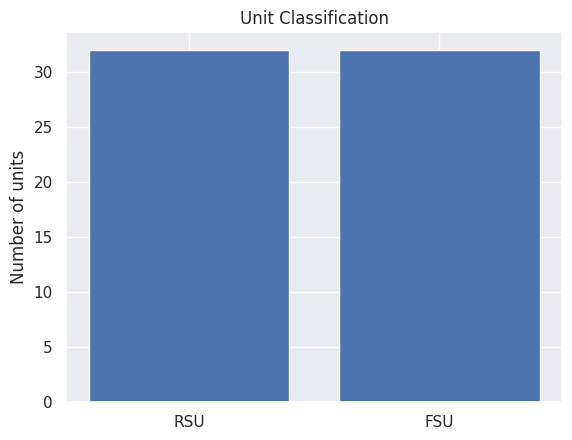

In [3]:
units = nwb.units
cell_types = units["celltype_label"][:]

# Plot unit counts by type
r = np.sum(cell_types == 1)
f = np.sum(cell_types == 2)
plt.bar(['RSU', 'FSU'], [r, f])
plt.ylabel('Number of units')
plt.title('Unit Classification')
plt.show()

## Trial Structure

Each recording contains 500 trials of ultrasound stimulation with:
- Stimulus delivered every 2.5s ± 10% jitter
- Trial duration: ~0.067s (67ms)

Number of trials: 500


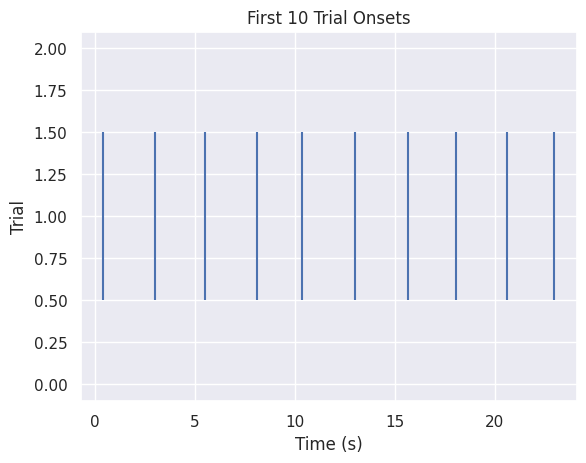

In [4]:
trials = nwb.intervals["trials"]
print(f"Number of trials: {len(trials['start_time'][:])}")

# Plot first 10 trials
plt.eventplot(trials["start_time"][:10])
plt.xlabel('Time (s)')
plt.ylabel('Trial')
plt.title('First 10 Trial Onsets')
plt.show()

## Example Unit Responses

Below we analyze example unit responses to the ultrasound stimulation:
1. Raster plots showing spike patterns
2. Peristimulus time histograms (PSTHs)

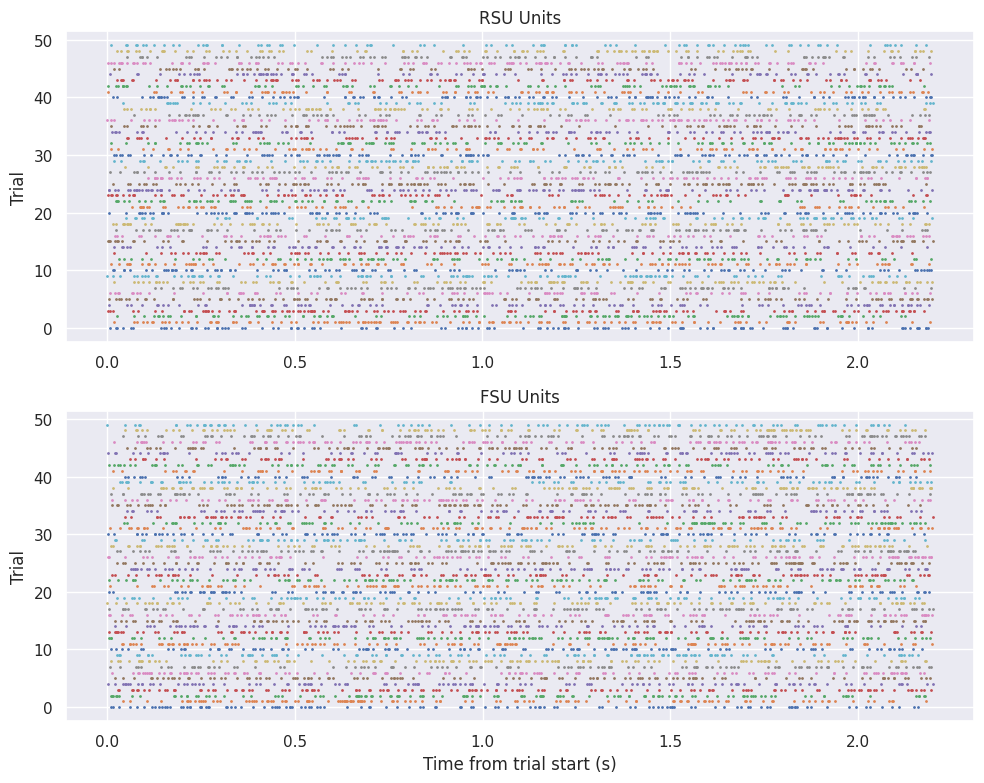

In [5]:
# Convert trials to DataFrame for easier access
import pandas as pd
trials_df = trials.to_dataframe().iloc[:50] # Use first 50 trials

# Select example units
rsu_units = [i for i, ct in enumerate(cell_types) if ct == 1][:5]
fsu_units = [i for i, ct in enumerate(cell_types) if ct == 2][:5]

# Create spike raster plots
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

for unit_idx in rsu_units[:3]:
    spikes = units["spike_times"][unit_idx]
    for trial_idx, (start, end) in enumerate(zip(trials_df["start_time"], trials_df["stop_time"])):
        trial_spikes = spikes[(spikes >= start) & (spikes <= end)] - start
        axs[0].scatter(trial_spikes, [trial_idx]*len(trial_spikes), s=1)
axs[0].set_title('RSU Units')
axs[0].set_ylabel('Trial')

for unit_idx in fsu_units[:3]:
    spikes = units["spike_times"][unit_idx]
    for trial_idx, (start, end) in enumerate(zip(trials_df["start_time"], trials_df["stop_time"])):
        trial_spikes = spikes[(spikes >= start) & (spikes <= end)] - start
        axs[1].scatter(trial_spikes, [trial_idx]*len(trial_spikes), s=1)
axs[1].set_title('FSU Units')
axs[1].set_xlabel('Time from trial start (s)')
axs[1].set_ylabel('Trial')

plt.tight_layout()
plt.show()

## Response Characteristics

Key observations:
- RSUs show variable responses with broader spike timing
- FSUs exhibit more precise, transient responses to stimulation
- Response patterns differ between RSU and FSU populations

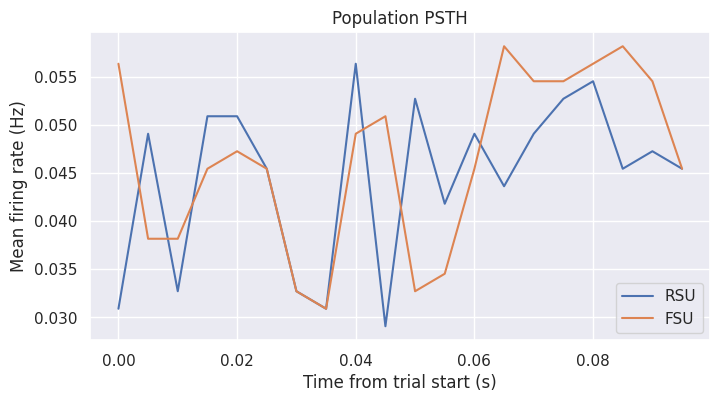

In [6]:
# Create PSTHs
def plot_psth(units_table, unit_indices, trials_df, bins=20):
    counts = []
    for unit_idx in unit_indices:
        # Get spike times for this unit
        spike_times = units_table.get_unit_spike_times(unit_idx)
        if len(spike_times) == 0:
            continue
            
        unit_counts = []
        for _, trial in trials_df.iterrows():
            start = trial["start_time"]
            end = trial["stop_time"]
            duration = end - start
            
            # Get spikes within trial window
            trial_spikes = spike_times[(spike_times >= start) & (spike_times <= end)] - start
            
            # Bin spikes and normalize by duration
            hist = np.histogram(trial_spikes, bins=bins)[0]
            unit_counts.append(hist/duration)
            
        if unit_counts:  # Only add if we have valid data
            counts.append(np.mean(unit_counts, axis=0))
            
    return np.mean(counts, axis=0) if counts else np.zeros(len(bins)-1)

# Set up bins and plot
bins = np.linspace(0, 0.1, 21)
rsu_units = [i for i, ct in enumerate(cell_types) if ct == 1][:5]
fsu_units = [i for i, ct in enumerate(cell_types) if ct == 2][:5]

rsu_rate = plot_psth(units, rsu_units, trials_df, bins)
fsu_rate = plot_psth(units, fsu_units, trials_df, bins)

plt.figure(figsize=(8,4))
plt.plot(bins[:-1], rsu_rate, label='RSU')
plt.plot(bins[:-1], fsu_rate, label='FSU')
plt.xlabel('Time from trial start (s)')
plt.ylabel('Mean firing rate (Hz)')
plt.title('Population PSTH')
plt.legend()
plt.show()

## Conclusion

This notebook demonstrates:
1. How to access and explore this Dandiset
2. Basic structure of the NWB files
3. Methods to analyze neural spike data
4. Example visualizations of unit responses

Future analyses could explore:
- Response differences between PRF conditions
- Correlation with electrode positions
- Spike-triggered averages of stimulus waveforms
- Population decoding approaches